# Задача 3. Реализация поиска кратчайших путей

Везде считаем, что вершины графа занумерованы подряд с нуля. Обратите внимание на то, что про граф заранее не известно, есть ли в нём циклы отрицательного веса.

Установим библиотеку `python-graphblas` и необходимые зависимости:

In [1]:
!pip install -q python-graphblas[default]
!pip install -q metagraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 3.3 MB/s eta 0:00:00


Подключим все необходимые для работы библиотеки:

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread

import networkx as nx
import matplotlib.pyplot as plt

Считаем разреженную матрицу, предварительно скачанную с сайта SuiteSparce Matrix Collection https://sparse.tamu.edu/:

In [ ]:
M = mmread('/content/karate.mtx')
M

"M_0"      nvals  nrows  ncols  dtype     format
gb.Matrix    156     34     34   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9   ...   24   25   26   27  \
0        1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0       ...                       
1   1.0       1.0  1.0                 1.0            ...                       
2   1.0  1.0       1.0                 1.0  1.0  1.0  ...                 1.0   
3   1.0  1.0  1.0                      1.0            ...                       
4   1.0                           1.0                 ...                       
5   1.0                           1.0                 ...                       
6   1.0                 1.0  1.0                      ...                       
7   1.0  1.0  1.0  1.0                                ...                       
8   1.0       1.0                                     ...                       
9             1.0                                     ...                       
10  1.0                 1.0  1.0                      ...                       
11  1.0                                               ...                       
12  1.0            1.0                                ...                       
13  1.0  1.0  1.0  1.0                                ...                       
14                                                    ...                       
15                                                    ...                       
16                           1.0  1.0                 ...                       
17  1.0  1.0                                          ...                       
18                                                    ...                       
19  1.0  1.0                                          ...                       
20                                                    ...                       
21  1.0  1.0                                          ...                       
22                                                    ...                       
23                                                    ...       1.0       1.0   
24                                                    ...       1.0       1.0   
25                                                    ...  1.0                  
26                                                    ...                       
27            1.0                                     ...  1.0                  
28            1.0                                     ...                       
29                                                    ...            1.0        
30       1.0                                1.0       ...                       
31  1.0                                               ...  1.0  1.0             
32            1.0                           1.0       ...                       
33                                          1.0  1.0  ...            1.0  1.0   

     28   29   30   31   32   33  
0                  1.0            
1             1.0                 
2   1.0                 1.0       
3                                 
4                                 
5                                 
6                                 
7                                 
8             1.0       1.0  1.0  
9                            1.0  
10                                
11                                
12                                
13                           1.0  
14                      1.0  1.0  
15                      1.0  1.0  
16                                
17                                
18                      1.0  1.0  
19                           1.0  
20                      1.0  1.0  
21                                
22                      1.0  1.0  
23       1.0            1.0  1.0  
24                 1.0            
25                 1.0            
26       1.0                 1.0  
27                           1.0  
28

Визуализируем граф:

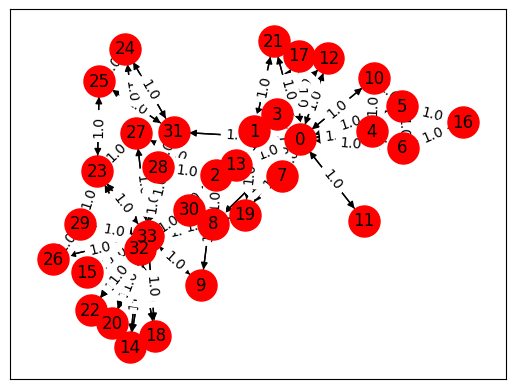

In [ ]:
gb.viz.draw(M)

1. Используя `python-graphblas` реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (`Bellman–Ford`).
 - Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и номер стартовой вершины.
 - Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно `float('inf')`.

In [3]:
def bellman_ford(matrix, start_vertex):
    # Количество вершин в графе
    num_vertices = matrix.nrows

    # Создание и инициализация вектора расстояний
    distances = Vector(matrix.dtype, num_vertices)
    distances[start_vertex] << 0.0

    # Основной цикл релаксации
    for _ in range(num_vertices - 1):
        # Копирование текущих расстояний в новый вектор
        new_distances = distances.dup()
        # Обновление расстояний с использованием матрично-векторного умножения
        new_distances(binary.min) << distances.vxm(matrix, semiring.min_plus)

        # Проверка, изменились ли расстояни
        if distances.isequal(new_distances):
            break
        distances = new_distances

    # Проверка на наличие циклов отрицательного веса
    check_distances = distances.dup()
    check_distances(binary.min) << distances.vxm(matrix, semiring.min_plus)

    if not distances.isequal(check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    # Преобразование расстояний в массив numpy для удобства
    final_distances = np.full(num_vertices, float('inf'))
    indices, values = distances.to_coo()
    for index, value in zip(indices, values):
        final_distances[index] = value

    return final_distances

In [ ]:
start_vertex = 0
distances = bellman_ford(M, start_vertex)
distances

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 3., 3., 2.,
       1., 3., 1., 3., 1., 3., 3., 2., 2., 3., 2., 2., 3., 2., 1., 2., 2.])

2. Используя `python-graphblas` реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм.
 - Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
 - Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно `float('inf')`.

In [4]:
def bellman_ford_modify(matrix, start_vertex_ar):
    num_vertices = matrix.nrows
    num_start_vertices = len(start_vertex_ar)

    # Создание и инициализация матрицы расстояний
    distances = Matrix(matrix.dtype, num_start_vertices, num_vertices)
    for i, start_vertex in enumerate(start_vertex_ar):
        distances[i, start_vertex] << 0.0

    # Основной цикл релаксации
    for _ in range(num_vertices - 1):
        new_distances = distances.dup()
        for i in range(num_start_vertices):
            new_distances[i, :](binary.min) << distances[i, :].vxm(matrix, semiring.min_plus)

        if distances.isequal(new_distances):
            break
        distances = new_distances

    # Проверка на наличие циклов отрицательного веса
    check_distances = distances.dup()
    for i in range(num_start_vertices):
        check_distances[i, :](binary.min) << distances[i, :].vxm(matrix, semiring.min_plus)

    if not distances.isequal(check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    # Формирование вывода
    output = {}
    for i, start_vertex in enumerate(start_vertex_ar):
        final_distances = np.full(num_vertices, float('inf'))
        indices, values = distances[i, :].to_coo()
        for index, value in zip(indices, values):
            final_distances[index] = value
        output[start_vertex] = final_distances

    return output

In [ ]:
start_vertex = [0, 1, 2, 3]
distances = bellman_ford_modify(M, start_vertex)
distances

{0: array([0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 3., 3., 2.,
        1., 3., 1., 3., 1., 3., 3., 2., 2., 3., 2., 2., 3., 2., 1., 2., 2.]),
 1: array([1., 0., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 3., 3., 3.,
        1., 3., 1., 3., 1., 3., 3., 3., 3., 3., 2., 2., 3., 1., 2., 2., 2.]),
 2: array([1., 1., 0., 1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 3.,
        2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 1., 1., 2., 2., 2., 1., 2.]),
 3: array([1., 1., 1., 0., 2., 2., 2., 1., 2., 2., 2., 2., 1., 1., 3., 3., 3.,
        2., 3., 2., 3., 2., 3., 3., 3., 3., 3., 2., 2., 3., 2., 2., 2., 2.])}

3. Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (`Floyd–Warshall` и вычисление транзитивного замыкания).
 - Функции принимают представление графа, удобное для неё (загрузка, конвертация реализованы отдельно).
 - Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно `float('inf')`.

In [5]:
def floyd_warshall(matrix):
    num_vertices = matrix.nrows
    distances = matrix.dup()

    # Основной цикл алгоритма Флойда-Уоршелла
    for k in range(num_vertices):
        cur_distances = distances.dup()

        # Введение переменных-матриц для удобства умножения
        D_col = Matrix(matrix.dtype, num_vertices, num_vertices)
        D_row = Matrix(matrix.dtype, num_vertices, num_vertices)

        D_col[:, k] = distances[:, k].dup()
        D_row[k, :] = distances[k, :].dup()

        cur_distances << D_col.mxm(D_row, semiring.min_plus)

        distances << distances.ewise_add(cur_distances, binary.min)

    # Проверка на наличие циклов отрицательного веса
    check_distances = distances.dup()

    for k in range(num_vertices):
        D_col = Matrix(matrix.dtype, num_vertices, num_vertices)
        D_row = Matrix(matrix.dtype, num_vertices, num_vertices)

        D_col[:, k] = distances[:, k].dup()
        D_row[k, :] = distances[k, :].dup()

        cur_distances << D_col.mxm(D_row, semiring.min_plus)

        check_distances << check_distances.ewise_add(cur_distances, binary.min)

        if not check_distances.isequal(distances):
            raise ValueError("Граф содержит цикл отрицательного веса")

    # Формирование вывода
    output = {}
    for i in range(num_vertices):
        final_distances = np.full(num_vertices, float('inf'))
        for j in range(num_vertices):
            if i == j:
                final_distances[j] = 0
            elif distances[i, j].value is None:
                final_distances[j] = float('inf')
            else:
                final_distances[j] = distances[i, j].value
        output[i] = np.array(final_distances)

    return output

In [ ]:
floyd_warshall(M)

{0: array([0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 3., 3., 2.,
        1., 3., 1., 3., 1., 3., 3., 2., 2., 3., 2., 2., 3., 2., 1., 2., 2.]),
 1: array([1., 0., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 3., 3., 3.,
        1., 3., 1., 3., 1., 3., 3., 3., 3., 3., 2., 2., 3., 1., 2., 2., 2.]),
 2: array([1., 1., 0., 1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 3.,
        2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 1., 1., 2., 2., 2., 1., 2.]),
 3: array([1., 1., 1., 0., 2., 2., 2., 1., 2., 2., 2., 2., 1., 1., 3., 3., 3.,
        2., 3., 2., 3., 2., 3., 3., 3., 3., 3., 2., 2., 3., 2., 2., 2., 2.]),
 4: array([1., 2., 2., 2., 0., 2., 1., 2., 2., 3., 1., 2., 2., 2., 4., 4., 2.,
        2., 4., 2., 4., 2., 4., 4., 3., 3., 4., 3., 3., 4., 3., 2., 3., 3.]),
 5: array([1., 2., 2., 2., 2., 0., 1., 2., 2., 3., 1., 2., 2., 2., 4., 4., 1.,
        2., 4., 2., 4., 2., 4., 4., 3., 3., 4., 3., 3., 4., 3., 2., 3., 3.]),
 6: array([1., 2., 2., 2., 1., 1., 0., 2., 2., 3., 2., 2.,

In [6]:
def transitive_closure(matrix):
    num_vertices = matrix.nrows

    # Инициализация единичной матрицы I
    I = Matrix(matrix.dtype, num_vertices, num_vertices)
    for i in range(num_vertices):
        I[i, i] << 1

    distances = I.dup()

    # Основной цикл для транзитивного замыкания
    for _ in range(num_vertices):
        new_distances = distances.dup()
        distances << distances.mxm(matrix, semiring.min_plus).ewise_add(I, binary.min)

        if distances.isequal(new_distances):
            break

    # Проверка на наличие циклов отрицательного веса
    check_distances = distances.dup()
    check_distances << check_distances.mxm(matrix, semiring.min_plus).ewise_add(I, binary.min)

    if not distances.isequal(check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    # Формирование вывода
    output = {}
    for i in range(num_vertices):
        final_distances = np.full(num_vertices, float('inf'))
        for j in range(num_vertices):
            if distances[i, j].value is None:
                final_distances[j] = float('inf')
            elif i == j:
                final_distances[j] = 0
            else:
                final_distances[j] = distances[i, j].value - 1
        output[i] = np.array(final_distances)

    return output

In [ ]:
transitive_closure(M)

{0: array([0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 3., 3., 2.,
        1., 3., 1., 3., 1., 3., 3., 2., 2., 3., 2., 2., 3., 2., 1., 2., 2.]),
 1: array([1., 0., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 3., 3., 3.,
        1., 3., 1., 3., 1., 3., 3., 3., 3., 3., 2., 2., 3., 1., 2., 2., 2.]),
 2: array([1., 1., 0., 1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 3.,
        2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 1., 1., 2., 2., 2., 1., 2.]),
 3: array([1., 1., 1., 0., 2., 2., 2., 1., 2., 2., 2., 2., 1., 1., 3., 3., 3.,
        2., 3., 2., 3., 2., 3., 3., 3., 3., 3., 2., 2., 3., 2., 2., 2., 2.]),
 4: array([1., 2., 2., 2., 0., 2., 1., 2., 2., 3., 1., 2., 2., 2., 4., 4., 2.,
        2., 4., 2., 4., 2., 4., 4., 3., 3., 4., 3., 3., 4., 3., 2., 3., 3.]),
 5: array([1., 2., 2., 2., 2., 0., 1., 2., 2., 3., 1., 2., 2., 2., 4., 4., 1.,
        2., 4., 2., 4., 2., 4., 4., 3., 3., 4., 3., 3., 4., 3., 2., 3., 3.]),
 6: array([1., 2., 2., 2., 1., 1., 0., 2., 2., 3., 2., 2.,

4. Добавим тесты для проверки корректности полученных реализаций:

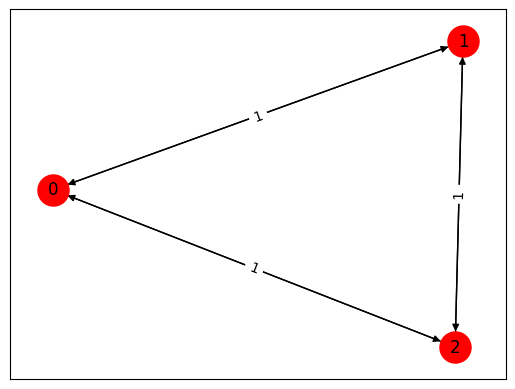

In [7]:
M1 = gb.Matrix.from_coo(
    [0, 0, 1, 1, 2, 2],
    [1, 2, 0, 2, 0, 1],
    [1, 1, 1, 1, 1, 1],
    nrows=3,
    ncols=3
)
gb.viz.draw(M1)

Функция `bellman_ford` со стартовой вершиной `0` должна вернуть массив [0., 1., 1.], что означает:

- Расстояние от вершины 0 до самой себя равно 0
- Расстояние от вершины 0 до вершины 1 равно 1.
- Расстояние от вершины 0 до вершины 2 равно 1.

In [ ]:
bellman_ford(M1, 0)

array([0., 1., 1.])

Результаты функций `bellman_ford_modify`, `floyd_warshall` и `transitive_closure` должны представлять собой список кортежей, где каждый кортеж содержит стартовую вершину и список уровней для всех вершин графа:

**1. (0, [0, 1, 1])**

*Для стартовой вершины 0:*
- Уровень вершины 0: 0 (начальная вершина).
- Уровень вершины 1: 1 (находится на расстоянии 1 ребра от вершины 0).
- Уровень вершины 2: 1 (находится на расстоянии 1 ребра от вершины 0).


**2. (1, [1, 0, 1])**

*Для стартовой вершины 1:*
- Уровень вершины 0: 1 (находится на расстоянии 1 ребра от вершины 1).
- Уровень вершины 1: 0 (начальная вершина).
- Уровень вершины 2: 1 (находится на расстоянии 1 ребра от вершины 1).


**3. (2, [1, 1, 0])**

*Для стартовой вершины 2:*
- Уровень вершины 0: 1 (находится на расстоянии 1 ребра от вершины 2).
- Уровень вершины 1: 1 (находится на расстоянии 1 ребра от вершины 2).
- Уровень вершины 2: 0 (начальная вершина).

In [ ]:
bellman_ford_modify(M1, [0, 1, 2])

{0: array([0., 1., 1.]), 1: array([1., 0., 1.]), 2: array([1., 1., 0.])}

In [ ]:
floyd_warshall(M1)

{0: array([0., 1., 1.]), 1: array([1., 0., 1.]), 2: array([1., 1., 0.])}

In [ ]:
transitive_closure(M1)

{0: array([0., 1., 1.]), 1: array([1., 0., 1.]), 2: array([1., 1., 0.])}

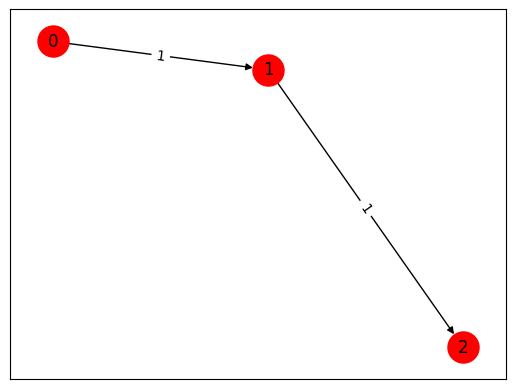

In [ ]:
M2 = gb.Matrix.from_coo(
    [0, 1],
    [1, 2],
    [1, 1],
    nrows=3,
    ncols=3
)
gb.viz.draw(M2)

Функция `bellman_ford` со стартовой вершиной `0` должна вернуть массив [0., 1., 2.], что означает:

- Расстояние от вершины 0 до самой себя равно 0
- Расстояние от вершины 0 до вершины 1 равно 1.
- Расстояние от вершины 0 до вершины 2 равно 2.

In [ ]:
bellman_ford(M2, 0)

array([0., 1., 2.])

Результаты функций `bellman_ford_modify`, `floyd_warshall` и `transitive_closure` должны представлять собой список кортежей, где каждый кортеж содержит стартовую вершину и список уровней для всех вершин графа:

**1. (0, [0, 1, 2]):**

*Для стартовой вершины 0:*

- Вершина 0: начальная вершина, уровень 0.
- Вершина 1: достигается из вершины 0 за 1 шаг.
- Вершина 2: достигается из вершины 0 через вершину 1 за 2 шага.

**2. (1, [inf, 0, 1]):**

*Для стартовой вершины 1:*

- Вершина 0: недостижима из вершины 1, уровень -1.
- Вершина 1: начальная вершина, уровень 0.
- Вершина 2: достигается из вершины 1 за 1 шаг.

**3. (2, [inf, inf, 0]):**

*Для стартовой вершины 2:*

- Вершина 0: недостижима из вершины 2, уровень -1.
- Вершина 1: недостижима из вершины 2, уровень -1.
- Вершина 2: начальная вершина, уровень 0.

In [ ]:
bellman_ford_modify(M2, [0, 1, 2])

{0: array([0., 1., 2.]), 1: array([inf,  0.,  1.]), 2: array([inf, inf,  0.])}

In [ ]:
floyd_warshall(M2)

{0: array([0., 1., 2.]), 1: array([inf,  0.,  1.]), 2: array([inf, inf,  0.])}

In [ ]:
transitive_closure(M2)

{0: array([0., 1., 2.]), 1: array([inf,  0.,  1.]), 2: array([inf, inf,  0.])}

5. Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количества стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).

In [8]:
import random
import matplotlib.pyplot as plt
import timeit

def generate_random_graph(num_vertices, num_edges):
    # Создаем пустые списки для хранения индексов и значений ребер
    indices_from = []
    indices_to = []
    values = []

    # Генерируем случайные ребра
    edges_added = 0
    while edges_added < num_edges:
        # Генерируем случайную пару вершин
        vertex1 = random.randint(0, num_vertices - 1)
        vertex2 = random.randint(0, num_vertices - 1)

        # Проверяем, что вершины различны и ребро еще не добавлено
        if vertex1 != vertex2 and (vertex1, vertex2) not in zip(indices_from, indices_to):
            # Добавляем индексы вершин и их симметричные пары
            indices_from.append(vertex1)
            indices_to.append(vertex2)
            indices_from.append(vertex2)
            indices_to.append(vertex1)
            # Добавляем значения ребер
            values.extend([1, 1])
            edges_added += 1
    # Создаем COO матрицу из списков индексов и значений
    coo_matrix = gb.Matrix.from_coo(indices_from, indices_to, values, nrows=num_vertices, ncols=num_vertices)
    return coo_matrix

Processed random graph with 10 vertices.
Processed random graph with 25 vertices.
Processed random graph with 50 vertices.
Processed random graph with 100 vertices.
Processed random graph with 200 vertices.
Processed random graph with 250 vertices.
Processed random graph with 300 vertices.


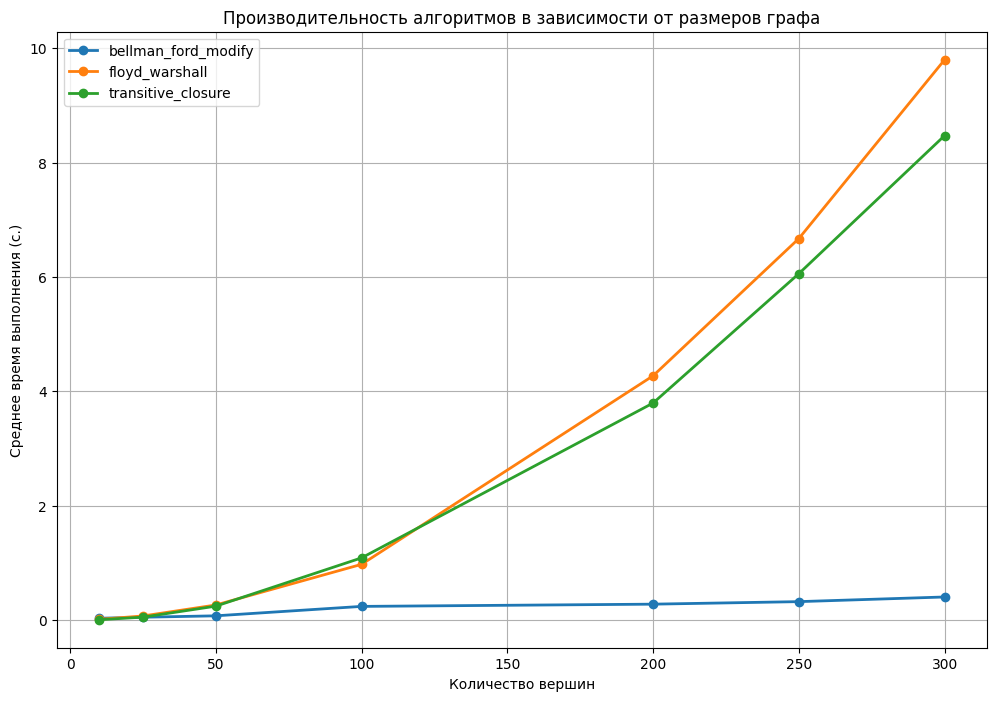

In [11]:
def test_performance(A, functions):
    times = {}
    num_vertices = A.shape[0]
    for func in functions:
        if func.__name__ in ['bellman_ford_modify']:
            t = timeit.timeit(lambda: func(A, list(range(num_vertices))), number=10)
        else:
            t = timeit.timeit(lambda: func(A), number=10)
        times[func.__name__] = t / 10  # Среднее время выполнения
    return times

# Словарь для хранения данных времени выполнения
functions = [bellman_ford_modify, floyd_warshall, transitive_closure]
times_data = {func.__name__: [] for func in functions}
vertex_counts = []

# Генерация случайных графов и тестирование на них
graph_sizes = [10, 25, 50, 100, 200, 250, 300]
sparsity = 10  # 10% рёбер

for size in graph_sizes:
    num_edges = int((sparsity / 100) * size * (size - 1) / 2)
    A = generate_random_graph(size, num_edges)
    vertex_counts.append(size)
    times = test_performance(A, functions)
    for name, time in times.items():
        times_data[name].append(time)
    print(f"Processed random graph with {size} vertices.")

# Построение графика
plt.figure(figsize=(12, 8))
for name, times in times_data.items():
    plt.plot(vertex_counts, times, label=name, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Количество вершин')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность алгоритмов в зависимости от размеров графа')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:**

**Bellman-Ford (модифицированный):**

- Производительность: Модифицированный алгоритм Bellman-Ford показывает наименьшее время выполнения по сравнению с алгоритмами Floyd-Warshall и Transitive Closure для всех размеров графа, представленных на графике.
- Рост времени выполнения: Время выполнения алгоритма растет линейно с увеличением количества вершин, что соответствует его теоретической сложности
`O(kVE)`.

**Floyd-Warshall:**

- Производительность: Алгоритм Floyd-Warshall демонстрирует значительно большее время выполнения по сравнению с Bellman-Ford и Transitive Closure, особенно на больших графах.
- Рост времени выполнения: Время выполнения алгоритма растет кубически с увеличением количества вершин, что соответствует его теоретической сложности
`𝑂(𝑉3)`.

**Transitive Closure:**

- Производительность: Алгоритм Transitive Closure показывает лучшее время выполнения, чем Floyd-Warshall, но хуже, чем Bellman-Ford.
- Рост времени выполнения: Время выполнения также растет кубически с увеличением количества вершин, что соответствует теоретической сложности
`𝑂(𝑉3)`.

Processed random graph with 100 vertices and sparsity 5%.
Processed random graph with 100 vertices and sparsity 10%.
Processed random graph with 100 vertices and sparsity 20%.
Processed random graph with 100 vertices and sparsity 30%.
Processed random graph with 100 vertices and sparsity 40%.
Processed random graph with 100 vertices and sparsity 50%.
Processed random graph with 100 vertices and sparsity 60%.
Processed random graph with 100 vertices and sparsity 70%.
Processed random graph with 100 vertices and sparsity 80%.
Processed random graph with 100 vertices and sparsity 90%.


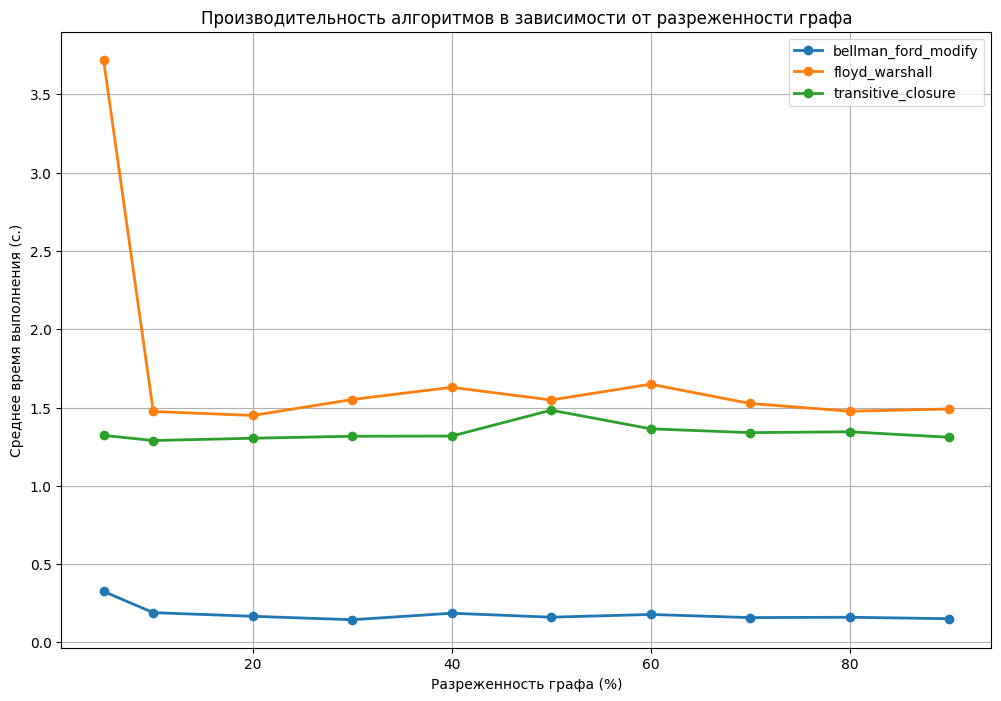

In [9]:
functions = [bellman_ford_modify, floyd_warshall, transitive_closure]
times_data = {func.__name__: [] for func in functions}
sparsity_levels = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
fixed_vertex_count = 100

# Генерация случайных графов и тестирование на них
for sparsity in sparsity_levels:
    num_edges = int((sparsity / 100) * fixed_vertex_count * (fixed_vertex_count - 1) / 2)
    A = generate_random_graph(fixed_vertex_count, num_edges)
    times = test_performance(A, functions)
    for name, time in times.items():
        times_data[name].append(time)
    print(f"Processed random graph with {fixed_vertex_count} vertices and sparsity {sparsity}%.")

# Построение графика
plt.figure(figsize=(12, 8))
for name, times in times_data.items():
    plt.plot(sparsity_levels, times, label=name, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Разреженность графа (%)')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность алгоритмов в зависимости от разреженности графа')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:**

Алгоритм `bellman_ford_modify` показывает наименьшее время выполнения по сравнению с алгоритмами `Floyd-Warshall` и `Transitive Closure` для всех уровней разреженности. Это делает его предпочтительным для задач, где разреженность графа может значительно варьироваться.


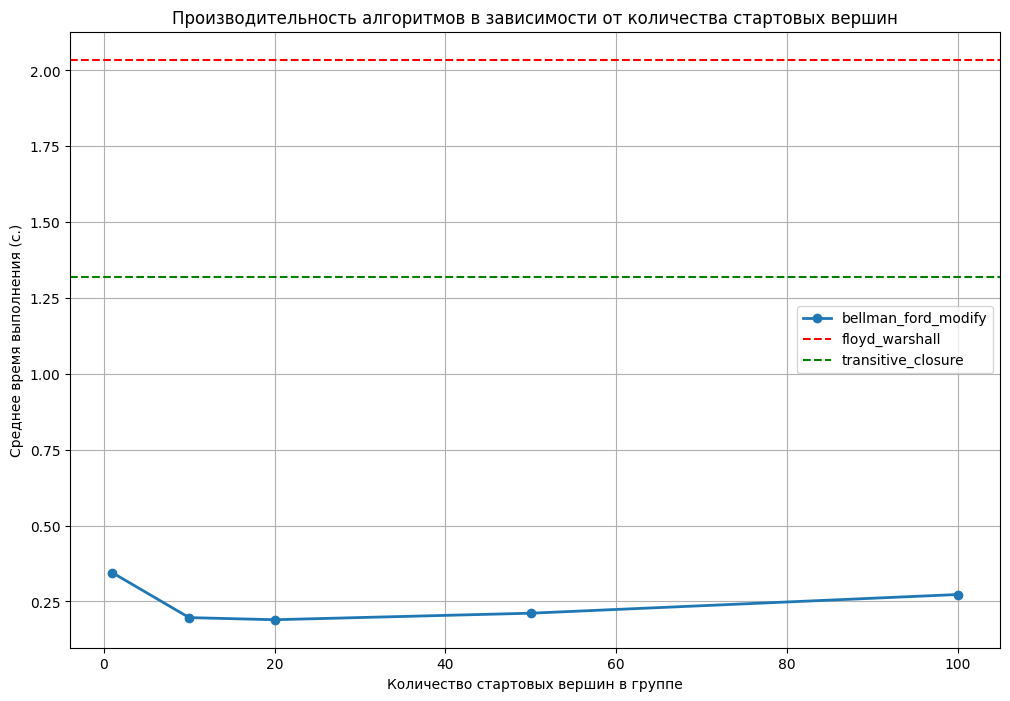

In [12]:
def test_performance(A, start_vertices, functions):
    times = {}
    num_vertices = A.shape[0]
    for func in functions:
        if func.__name__ in ['bellman_ford_modify']:
            t = timeit.timeit(lambda: func(A, start_vertices), number=10)
        else:
            t = timeit.timeit(lambda: func(A), number=10)
        times[func.__name__] = t / 10  # Среднее время выполнения
    return times

def test_bellman_ford_multiple_sources(A, group_sizes):
    times = {}
    num_vertices = A.shape[0]
    for size in group_sizes:
        start_vertices = [list(range(i, min(i + size, num_vertices))) for i in range(0, num_vertices, size)]
        total_time = 0
        for group in start_vertices:
            t = timeit.timeit(lambda: bellman_ford_modify(A, group), number=10)
            total_time += t / 10  # Среднее время выполнения для группы
        times[size] = total_time
    return times

# Параметры для тестирования
num_vertices = 1000
sparsity = 10  # 10% рёбер
num_edges = int((sparsity / 100) * num_vertices * (num_vertices - 1) / 2)
group_sizes = [1, 10, 20, 50, 100]

# Генерация случайного графа
A = generate_random_graph(num_vertices, num_edges)

# Тестирование производительности Bellman-Ford с различным количеством стартовых вершин
bf_times = test_bellman_ford_multiple_sources(A, group_sizes)

# Тестирование Floyd-Warshall и Transitive Closure
other_times = test_performance(A, [], [floyd_warshall, transitive_closure])
fw_time = other_times['floyd_warshall']
tc_time = other_times['transitive_closure']

bf_group_sizes = list(bf_times.keys())
bf_group_times = list(bf_times.values())

plt.figure(figsize=(12, 8))
plt.plot(bf_group_sizes, bf_group_times, label='bellman_ford_modify', marker='o', linestyle='-', linewidth=2)
plt.axhline(y=fw_time, color='r', linestyle='--', label='floyd_warshall')
plt.axhline(y=tc_time, color='g', linestyle='--', label='transitive_closure')
plt.xlabel('Количество стартовых вершин в группе')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность алгоритмов в зависимости от количества стартовых вершин')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:**

- На основании полученных данных можно сделать вывод, что использование алгоритмов `Floyd-Warshall` и `Transitive Closure` для всех пар вершин становится целесообразным только в очень специфических условиях, где все вершины графа должны быть учтены, и граф не является сильно разреженным. В остальных случаях модифицированный Bellman-Ford показывает лучшую производительность и является предпочтительным выбором.

- Рассмотрим разреженный граф, где количество рёбер $E≈V$. Тогда для модифицированного `Bellman-Ford`:$T_{BF}\approx k⋅V^2$. Для `Floyd-Warshall` и `Transitive Closure`: $𝑇_{𝐹𝑊}\approx 𝑉^3$ и $𝑇_{TC}\approx 𝑉^3$. Нам нужно найти такое значение $k$, при котором: $𝑘V^2 \approx 𝑉^3$. Это означает: $k \approx V$. То есть, когда количество стартовых вершин $k$ становится порядка $𝑉$(количество всех вершин в графе), время выполнения модифицированного `Bellman-Ford` становится сравнимым с временем выполнения `Floyd-Warshall` и `Transitive Closure`.

Processed /content/mycielskian3.mtx with 5 vertices.
Processed /content/mycielskian4.mtx with 11 vertices.
Processed /content/lap_25.mtx with 25 vertices.
Processed /content/bcspwr02.mtx with 49 vertices.
Processed /content/dolphins.mtx with 62 vertices.
Processed /content/ash85.mtx with 85 vertices.
Processed /content/bcspwr03.mtx with 118 vertices.
Processed /content/can_161.mtx with 161 vertices.
Processed /content/dwt_198.mtx with 198 vertices.
Processed /content/ash292.mtx with 292 vertices.


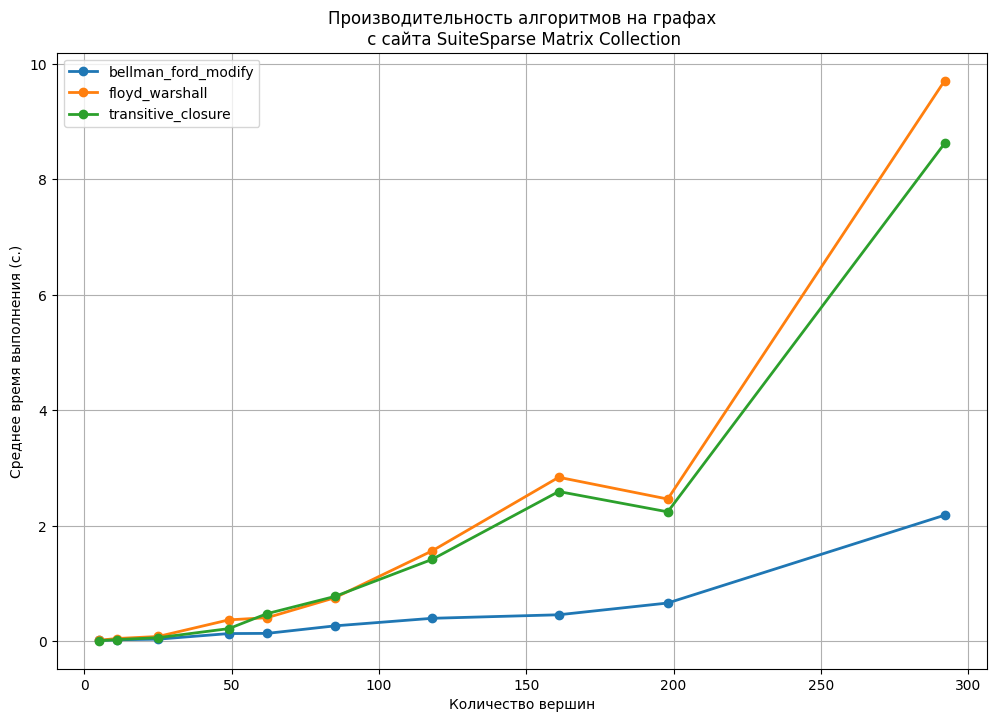

In [22]:
files = [
    '/content/mycielskian3.mtx',
    '/content/mycielskian4.mtx',
    '/content/lap_25.mtx',
    '/content/bcspwr02.mtx',
    '/content/dolphins.mtx',
    '/content/ash85.mtx',
    '/content/bcspwr03.mtx',
    '/content/can_161.mtx',
    '/content/dwt_198.mtx',
    '/content/ash292.mtx'
]

# Словарь для хранения данных времени выполнения
times_data = {func.__name__: [] for func in [bellman_ford_modify, floyd_warshall, transitive_closure]}
vertex_counts = []

# Тестирование на реальных графах из файлов
for file_path in files:
    A = mmread(file_path)
    num_vertices = A.shape[0]
    vertex_counts.append(num_vertices)
    start_vertices = list(range(num_vertices))
    times = test_performance(A, start_vertices, [bellman_ford_modify, floyd_warshall, transitive_closure])
    for name, time in times.items():
        times_data[name].append(time)
    print(f"Processed {file_path} with {num_vertices} vertices.")

plt.figure(figsize=(12, 8))
for name, times in times_data.items():
    plt.plot(vertex_counts, times, label=name, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Количество вершин')
plt.ylabel('Среднее время выполнения (с.)')
plt.title('Производительность алгоритмов на графах\n с сайта SuiteSparse Matrix Collection')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:**
Алгоритм `Bellman-Ford` (bellman_ford_modify) демонстрирует наилучшую производительность среди протестированных алгоритмов, особенно на крупных графах с числом вершин более 150. Он показывает стабильное и относительно низкое время выполнения, в то время как алгоритмы `Floyd-Warshall` и `Transitive Closure` начинают значительно ухудшаться по производительности на графах с числом вершин более 100. Для графов с меньшим числом вершин (менее 100) все три алгоритма демонстрируют схожую производительность, однако для крупных графов `Bellman-Ford` является наиболее эффективным выбором.

6. Оценить эффект от использования `push/pull direction optimization` для векторно-матричных операциях в алгоритмах. Попробовать разные стратегии (всегда `push`, всегда `pull`, использовать порог наполненности вектора и т.д.).

In [14]:
def bellman_ford_push(matrix, start_vertex_ar):
    num_vertices = matrix.shape[0]
    num_start_vertices = len(start_vertex_ar)

    distances = np.full((num_start_vertices, num_vertices), np.inf)
    for i, start_vertex in enumerate(start_vertex_ar):
        distances[i, start_vertex] = 0.0

    for _ in range(num_vertices - 1):
        new_distances = distances.copy()
        for i in range(num_start_vertices):
            for u in range(num_vertices):
                for v in range(num_vertices):
                    if distances[i, u] + matrix[u, v] < new_distances[i, v]:
                        new_distances[i, v] = distances[i, u] + matrix[u, v]

        if np.array_equal(distances, new_distances):
            break
        distances = new_distances

    check_distances = distances.copy()
    for i in range(num_start_vertices):
        for u in range(num_vertices):
            for v in range(num_vertices):
                if distances[i, u] + matrix[u, v] < check_distances[i, v]:
                    check_distances[i, v] = distances[i, u] + matrix[u, v]

    if not np.array_equal(distances, check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    output = {}
    for i, start_vertex in enumerate(start_vertex_ar):
        final_distances = np.full(num_vertices, float('inf'))
        for v in range(num_vertices):
            final_distances[v] = distances[i, v]
        output[start_vertex] = final_distances

    return output


def bellman_ford_pull(matrix, start_vertex_ar):
    num_vertices = matrix.shape[0]
    num_start_vertices = len(start_vertex_ar)

    distances = np.full((num_start_vertices, num_vertices), np.inf)
    for i, start_vertex in enumerate(start_vertex_ar):
        distances[i, start_vertex] = 0.0

    for _ in range(num_vertices - 1):
        new_distances = distances.copy()
        for v in range(num_vertices):
            for i in range(num_start_vertices):
                for u in range(num_vertices):
                    if distances[i, u] + matrix[u, v] < new_distances[i, v]:
                        new_distances[i, v] = distances[i, u] + matrix[u, v]

        if np.array_equal(distances, new_distances):
            break
        distances = new_distances

    check_distances = distances.copy()
    for v in range(num_vertices):
        for i in range(num_start_vertices):
            for u in range(num_vertices):
                if distances[i, u] + matrix[u, v] < check_distances[i, v]:
                    check_distances[i, v] = distances[i, u] + matrix[u, v]

    if not np.array_equal(distances, check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    output = {}
    for i, start_vertex in enumerate(start_vertex_ar):
        final_distances = np.full(num_vertices, float('inf'))
        for v in range(num_vertices):
            final_distances[v] = distances[i, v]
        output[start_vertex] = final_distances

    return output


def bellman_ford_hybrid(matrix, start_vertex_ar, threshold):
    num_vertices = matrix.shape[0]
    num_start_vertices = len(start_vertex_ar)

    distances = np.full((num_start_vertices, num_vertices), np.inf)
    for i, start_vertex in enumerate(start_vertex_ar):
        distances[i, start_vertex] = 0.0

    for _ in range(num_vertices - 1):
        new_distances = distances.copy()
        for i in range(num_start_vertices):
            non_zero_count = np.count_nonzero(distances[i, :])
            density = non_zero_count / num_vertices

            if density > threshold:
                for u in range(num_vertices):
                    for v in range(num_vertices):
                        if distances[i, u] + matrix[u, v] < new_distances[i, v]:
                            new_distances[i, v] = distances[i, u] + matrix[u, v]
            else:
                for v in range(num_vertices):
                    for u in range(num_vertices):
                        if distances[i, u] + matrix[u, v] < new_distances[i, v]:
                            new_distances[i, v] = distances[i, u] + matrix[u, v]

        if np.array_equal(distances, new_distances):
            break
        distances = new_distances

    check_distances = distances.copy()
    for i in range(num_start_vertices):
        for u in range(num_vertices):
            for v in range(num_vertices):
                if distances[i, u] + matrix[u, v] < check_distances[i, v]:
                    check_distances[i, v] = distances[i, u] + matrix[u, v]

    if not np.array_equal(distances, check_distances):
        raise ValueError("Граф содержит цикл отрицательного веса")

    output = {}
    for i, start_vertex in enumerate(start_vertex_ar):
        final_distances = np.full(num_vertices, float('inf'))
        for v in range(num_vertices):
            final_distances[v] = distances[i, v]
        output[start_vertex] = final_distances

    return output


def evaluate_strategies(matrix, start_vertex_ar, strategies, threshold=None):
    times = {}
    for strategy in strategies:
        if strategy == 'push':
            t = timeit.timeit(lambda: bellman_ford_push(matrix, start_vertex_ar), number=10)
        elif strategy == 'pull':
            t = timeit.timeit(lambda: bellman_ford_pull(matrix, start_vertex_ar), number=10)
        elif strategy == 'hybrid' and threshold is not None:
            t = timeit.timeit(lambda: bellman_ford_hybrid(matrix, start_vertex_ar, threshold), number=10)
        else:
            raise ValueError("Неизвестная стратегия или не указан threshold для hybrid")
        times[strategy] = t / 10
    return times

# Параметры для тестирования
num_vertices = 100
sparsity = 10  # 10% рёбер
num_edges = int((sparsity / 100) * num_vertices * (num_vertices - 1) / 2)
group_sizes = [1, 10, 20, 50, 100]

# Генерация случайного графа
A = generate_random_graph(num_vertices, num_edges)

# Тестирование стратегий
strategies = ['push', 'pull', 'hybrid']
start_vertex_ar = list(range(10))
threshold = 0.5  # Порог наполненности вектора (50%)
strategy_times = evaluate_strategies(A, start_vertex_ar, strategies, threshold)

print(strategy_times)

{'push': 0.6619332197999939, 'pull': 0.5123824943000272, 'hybrid': 0.6314735981000013}


**Выводы:**
- `Pull` стратегия оказалась наиболее эффективной среди протестированных. Она показала наименьшее время выполнения, что делает её предпочтительной для данного набора данных.
- `Push` стратегия показала наихудшее время выполнения. Вероятно, она менее эффективна для данного графа и набора стартовых вершин.
- Гибридная стратегия, хотя и лучше, чем `push`, всё же уступает стратегии `pull`. Это может указывать на то, что текущий порог наполненности (50%) не является оптимальным или что сама гибридная стратегия менее эффективна для данного случая.
- Производительность может варьироваться в зависимости от характеристик входного графа и начальных условий.